### MLP for ECG signal classification

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP  (Replace this with your CNN and rename the file)

In [53]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=187, out_features=256)
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.linear2 = nn.Linear(256, 128)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.linear3 = nn.Linear(128, 64)
        self.pool3 = nn.AvgPool1d(kernel_size=2, stride=2)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.linear4 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self.linear5 = nn.Linear(32, 16)
        self.linear6 = nn.Linear(16, 5)
    def forward(self, x):
        y=self.linear1(x)
        y=nnF.relu(y)
        
        pool_1=self.pool1(y)
        y=self.linear2(y)
        y=nnF.relu(y)
        print(y.shape,pool_1.shape)
        y=y+pool_1
        
        pool_2=self.pool2(y)
        y=self.linear3(self.bn3(y))
        y=nnF.relu(y)
        print(y.shape,pool_2.shape)
        y=y+pool_2
        
        pool_3=self.pool3(y)
        y=self.linear4(self.bn4(y))
        y=nnF.relu(y)
        print(y.shape,pool_3.shape)
        y=y+pool_3
        
        y=self.linear5(self.bn5(y))
        y=nnF.relu(y)
    
        z=self.linear6(y)
        print(z.shape)
        
        return z

In [54]:
#Test with randomly generated data to confirm dimensions of each layer align as expected
model=Net()
x=torch.rand(2,187) 
z=model(x)

torch.Size([2, 128]) torch.Size([2, 128])
torch.Size([2, 64]) torch.Size([2, 64])
torch.Size([2, 32]) torch.Size([2, 32])
torch.Size([2, 5])


In [55]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [56]:
def cal_accuracy(confusion):
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train MLP

In [57]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Z = model(X)
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()
        Yp = Z.data.max(dim=1)[1]             
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=sample_count    
    return loss_train, acc_train

## The function to test MLP 

In [58]:
def test(model, device, dataloader):
    model.eval()
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): 
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)
            Yp = Z.data.max(dim=1)[1]
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders

In [59]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):        
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        return x, y

In [60]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [61]:
X=X.values
print(X.shape)
Y=Y.values
print(Y.shape)
Y=Y.reshape(-1)
print(Y.shape)

(3841, 187)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

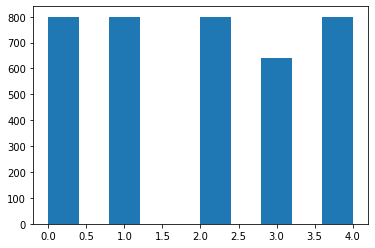

In [64]:
plt.hist(Y)

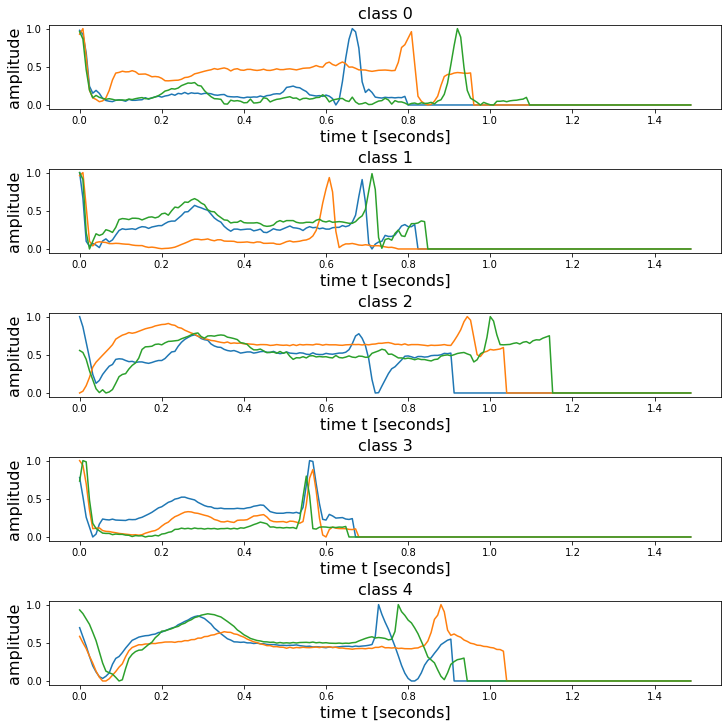

In [65]:
fs=125  #frequency
Ts=1/fs #interval
N=187 # number of timepoints
Duration=N*Ts # duration of signal
t=np.linspace(0, Duration-Ts, N) 
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [67]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [68]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Train model and send training task to GPU if have access

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
x=dataset_train[0][0]
x=x.view(1,187).to(device)
model.eval()
z=model(x)

torch.Size([1, 128]) torch.Size([1, 128])
torch.Size([1, 64]) torch.Size([1, 64])
torch.Size([1, 32]) torch.Size([1, 32])
torch.Size([1, 5])


In [70]:
y_hat=nnF.softmax(z, dim=1)
y_hat

tensor([[0.2140, 0.1563, 0.1711, 0.2526, 0.2061]], grad_fn=<SoftmaxBackward0>)

use stochastic gradient descent as the optimization method

In [71]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [72]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [ ]:
for epoch in range(epoch_save+1, 100):
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('ECG_MLP_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

## Plot accuracy and loss per epoch, find the optimised model/tune hyperparameters, and use that model on test set

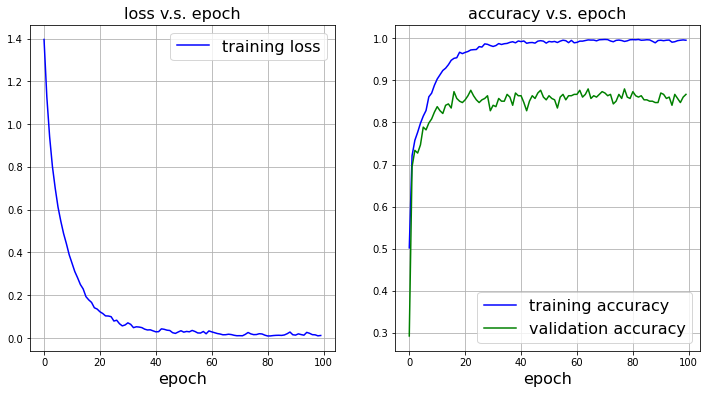

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [75]:
best_epoch=np.argmax(acc_val_list)
best_epoch

64

In [76]:
checkpoint=torch.load('ECG_MLP_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [77]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([128, 128]) torch.Size([128, 128])
torch.Size([128, 64]) torch.Size([128, 64])
torch.Size([128, 32]) torch.Size([128, 32])
torch.Size([128, 5])
torch.Size([1, 128]) torch.Size([1, 128])
torch.Size([1, 64]) torch.Si